# Exogenous Causal Forest

In [5]:
import numpy as np
import scipy.special
np.random.seed(123)
n_samples = 5000
n_features = 100
n_treatments = 3
n_outputs = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + X[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [6]:
from econml.grf import CausalForest
est = CausalForest(criterion='mse', n_estimators=1000, min_samples_leaf=20,
                   min_impurity_decrease = -np.inf, max_samples=0.5,
                   honest=True, verbose=1, n_jobs=-1, random_state=1235)

In [7]:
est.fit(X, T, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   42.8s finished


CausalForest(max_samples=0.5, min_impurity_decrease=-inf, min_samples_leaf=20,
             n_estimators=1000, n_jobs=-1, random_state=1235, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


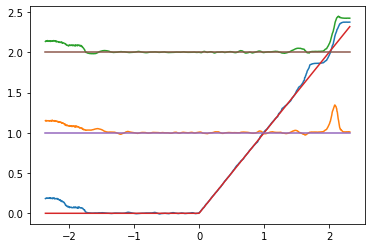

In [8]:
import matplotlib.pyplot as plt
pred_test_point = est.predict(X_test)
plt.plot(X_test[:, 0], pred_test_point)
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

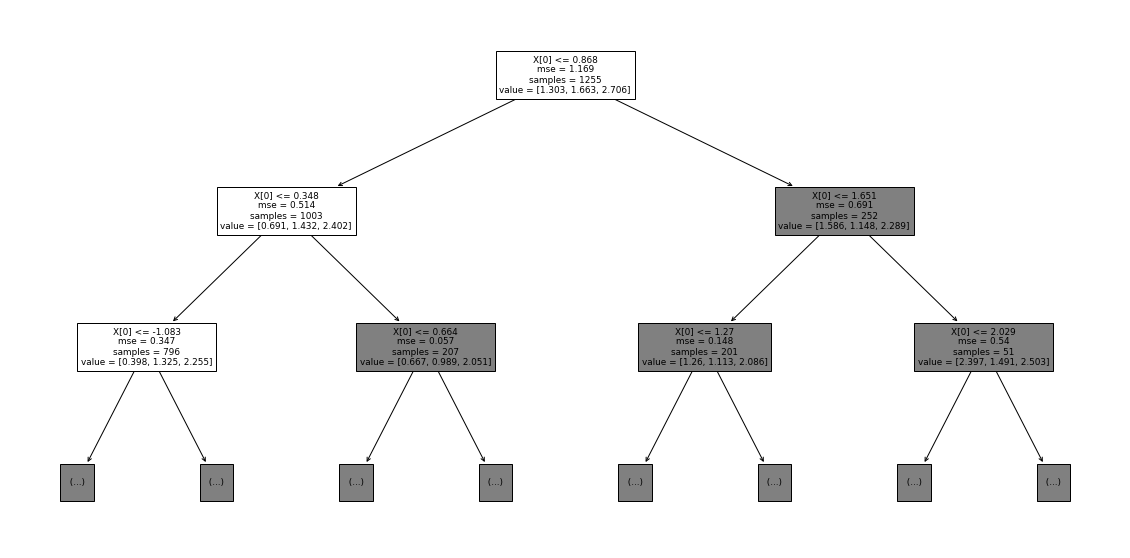

In [9]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(est[1], impurity=True, max_depth=2)
plt.show()

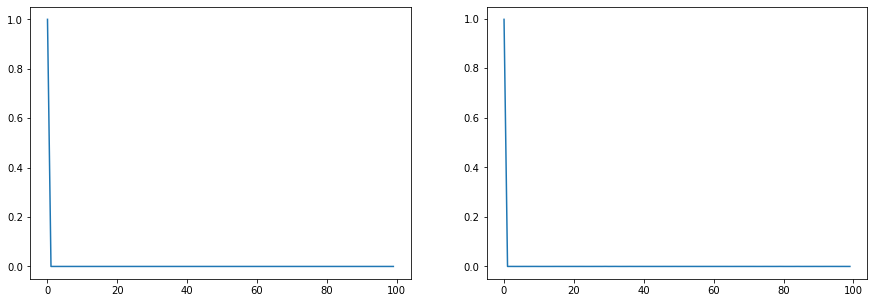

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(est.feature_importances_)
plt.subplot(1, 2, 2)
plt.plot(est.feature_heterogeneity_importances_)
plt.show()

In [11]:
est.decision_path(X_test[:1])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


(<1x87034 sparse matrix of type '<class 'numpy.int64'>'
 	with 4972 stored elements in Compressed Sparse Row format>,
 array([    0,    81,   164, ..., 86870, 86953, 87034], dtype=int32))

In [12]:
est.apply(X_test[:1])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


array([[4, 4, 5, 4, 4, 4, 4, 4, 5, 4, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        3, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4,
        5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        5, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 3, 4,
        4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4,
        4, 4, 3, 4, 3, 4, 4, 4, 5, 4, 

# IV Causal Forest

In [13]:
import numpy as np
import scipy.special
np.random.seed(1227)
n_samples = 1000
n_features = 10
n_treatments = 1
n_outputs = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
Z = np.random.normal(0, 1, size=(n_samples, n_treatments))
X = np.random.normal(0, 1, size=(n_samples, n_features))
U = np.random.normal(0, .2, size=(n_samples, 1))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] += U[:, 0] + Z[:, t]
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 10*U[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [14]:
from econml.grf import CausalIVForest
est = CausalIVForest(criterion='mse', n_estimators=100, min_samples_leaf=20,
                   min_impurity_decrease = 0.001, max_samples=.9, max_depth=None,
                   honest=True, verbose=1, n_jobs=-1, random_state=123)

In [15]:
est.fit(X, T, y, Z=Z)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: A column-vector T was passed when a 1d array was expected. Please change the shape of T to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\econml\grf\_forest_classes.py:273: UserWarning: A column-vector Z was passed when a 1d array was expected. Please change the shape of Z to (n_samples,), for example using ravel().
  alpha = self.get_alpha(X, Taug, y, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


CausalIVForest(min_impurity_decrease=0.001, min_samples_leaf=20, n_jobs=-1,
               random_state=123, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


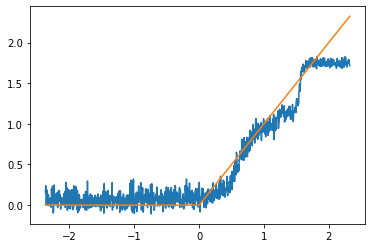

In [16]:
import matplotlib.pyplot as plt
pred_test_point = est.predict(X_test)
plt.plot(X_test[:, 0], pred_test_point)
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

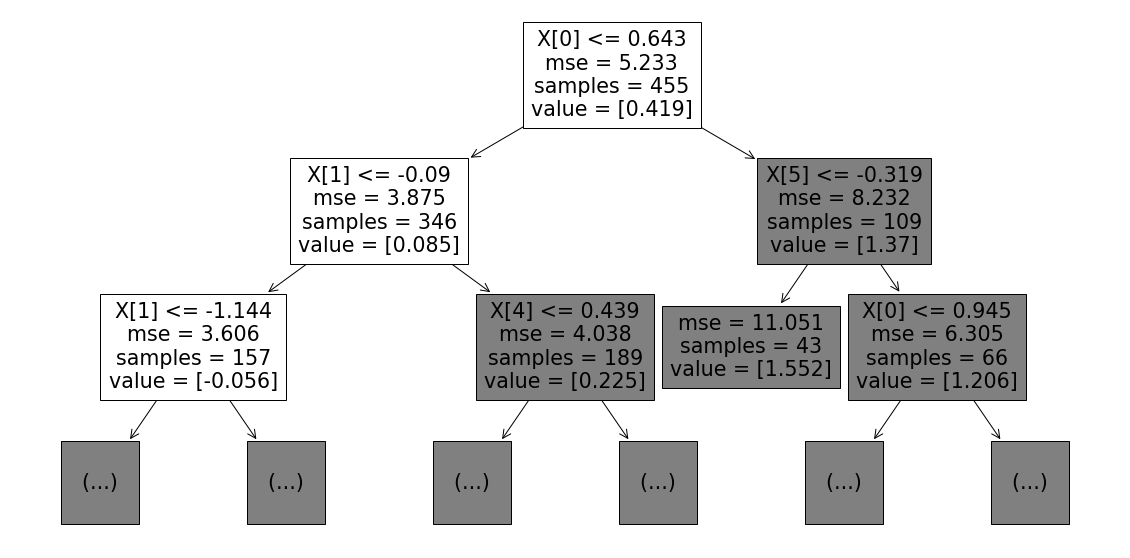

In [17]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

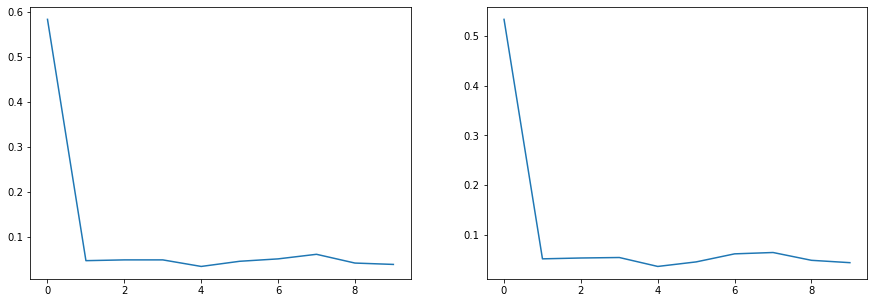

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(est.feature_importances_)
plt.subplot(1, 2, 2)
plt.plot(est.feature_heterogeneity_importances_)
plt.show()

In [19]:
est[0].decision_path(X_test[:1])

<1x31 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [20]:
est[0].apply(X_test[:1])

array([7], dtype=int64)